# Behavioral Cloning Project with Darknet53

## Introduction

The purpose of this project is to enable a car to predict a series of required steering wheel angles by cloning human driver's behavior in the simulator.

The project is structured in the three stages:
* Data - Colllection, exploratory data analysis, and creating data loader with Python generator
* Model - Implementing Darknet53 architecture in Keras
* Training - Experimenting to identify better hyperparameters for this dataset

----------------

While many alumni in this program implemented this project with the [NVIDIA model architecture](https://arxiv.org/abs/1604.07316) that works fine with the dataset, I wanted to try a different architecture that is light enough as well as performs well. That is why I selected Darknet53 - the backbone of [YOLOV3](https://pjreddie.com/media/files/papers/YOLOv3.pdf). With approximately around 40 million parameters on this implementation, Darknet53 can predict the steering wheel angles with only 6-epoch training (3 training on original dataset and 3 finetuning on additional dataset).

---------------
It turns out that most important stage here is the data collection and exploratory data analysis. 

At the beginning, I trained Darknet53 with the whole sample of the data provided by Udacity. As you can see in the Exploratory Data Analysis section, this dataset is heavily imbalanced - the steering wheel angles around 0 degree dominates the dataset. Using this dataset without balancing it created the model biased towards the straigt steering wheel angles, resulting in poor performance in the corners. This is explored in the data anlaysis section; as a result of the analysis, the dataset is then balanced with undersampling the average number of images from each interval (I used 50 intervals). 

The newly balanced dataset provides the succesful performance in the first corner before the bridge. However, this does not provide sufficient generalisation because once the car passes the bridge, it goes into the dirt patch that looks like a track in a way. This is why I had to collect additional data to train further. Despite additional data, the car drove worse as it turns out that in this project, 'garbage in and garbage out' holds true. My driving skill, both in real life and in the simulator, is terrible. Since the driver drove badly, the model performed worse. It required a lot of practice to get a good enough dataset to finetune the model further. Also, I swapped using keyboard control with using mouse control - it seems that the angle data generated by mouse control is superior to those by keyboard control.

To start the project, I imported the packages below to do data analysis, preparation and augmentation as well as to build and train the model.

### Import packages

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import cv2
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.transform import rotate
from skimage.filters import gaussian
from skimage.util import random_noise
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Conv2D, Activation, BatchNormalization, Dense, \
LeakyReLU, GlobalAveragePooling2D, Dropout, Flatten, Lambda, add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.initializers import he_normal
from keras.regularizers import l2
from typing import Collection
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Using TensorFlow backend.


As usual, I will random seed with 42 for the reproducibility of results.

In [4]:
np.random.seed(42)
random.seed(42)

## Data

This section encompasses three sections:

* Data Collection - I had to collect additional data because the model started to overfit depite data augmentation.
* Exploratory Data Analysis - With this process, I could identify the problems using the whole sample dataset provided by Udacity. I created the balanced resampled dataset.
* Data Preparation - I created a DataLoader class to preprocess and split the training and validation datasets. Augmentation methods were also implemented in this class.

### Data Collection

Initially, I used the sample data provided by Udacity. However, even with augmentation, this data was not sufficient for the 40-million parameters of Darknet53. I had to, therefore, collect additional data and this took a while since it was difficult to get good quality of data for the model to finetune.

I collected two-lap of the original direction on the normal track and three-lap of the reverse direction on the same track with the steering angles generated by mouse control.

### Exploratory Data Analysis

I imported the dataset in a Padas DataFrame to explore characteristics of the current dataset.

In [4]:
original_path = "add_data/origin_dir/extended_log.csv"

The important field here is the path to image and the steering angles.

In [20]:
origin_df = pd.read_csv(original_path)
origin_df.head()

,Unnamed: 0,image,steering_angle
0,0,IMG/center_2019_10_21_02_26_30_452.jpg,0.0
1,1,IMG/center_2019_10_21_02_26_30_522.jpg,0.0
2,2,IMG/center_2019_10_21_02_26_30_635.jpg,0.0
3,3,IMG/center_2019_10_21_02_26_30_777.jpg,0.0
4,4,IMG/center_2019_10_21_02_26_30_955.jpg,0.0


Additional dataset is up to 20,382 by utilising images taken from center, left and right cameras. When using left and right camera images, I had to adjust the steering angles' X axis (width) by +0.25 (left) and -0.25 (right) pixels, respectively.

In [21]:
len(origin_df)

20382

When creating the histogram of 50 intervals to count how many images are in each interval, it displays a heavily-imbalanced distribution.

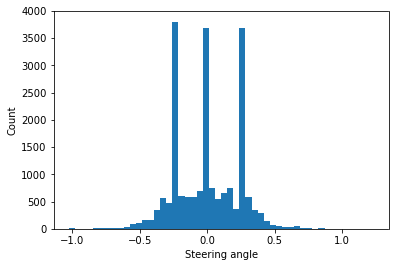

In [22]:
histogram = plt.hist(origin_df['steering_angle'], bins=50)
plt.xlabel("Steering angle")
plt.ylabel("Count")
plt.show(histogram)

As seen above, three intervals have the number of images larger than 3,500 while all other intervals has the number of images around or less than 500. In addition, there seems to be a small number of angles smaller than -1.0 and greater than 1.0. For the integrity, I removed the invalid steering angles that are less than -1.0 and larger than 1.0. 

Now, 20,372 images are left.

In [23]:
origin_df = origin_df.loc[(origin_df['steering_angle']>=-1.0) & (origin_df['steering_angle']<=1.0)]
len(origin_df)

20372

I reset the index for the dataframe in case I will need to use any loop method.

In [24]:
origin_df.reset_index()

,index,Unnamed: 0,image,steering_angle
0,0,0,IMG/center_2019_10_21_02_26_30_452.jpg,0.00
1,1,1,IMG/center_2019_10_21_02_26_30_522.jpg,0.00
2,2,2,IMG/center_2019_10_21_02_26_30_635.jpg,0.00
3,3,3,IMG/center_2019_10_21_02_26_30_777.jpg,0.00
4,4,4,IMG/center_2019_10_21_02_26_30_955.jpg,0.00
...,...,...,...,...
20367,20377,9883,IMG/right_2019_10_21_02_49_00_535.jpg,-0.25
20368,20378,9884,IMG/right_2019_10_21_02_49_00_608.jpg,-0.25
20369,20379,9885,IMG/right_2019_10_21_02_49_00_681.jpg,-0.25
20370,20380,9886,IMG/right_2019_10_21_02_49_00_759.jpg,-0.25


I wanted to look at the exact number of images for 50 intervals. To do so, I created a range of 51 points (i.e. every 0.04 step (2.0/50 intervals) -1 to 1). Then, count the images that are grouped between evert 0.04 step.

In [25]:
ranges = [x for x in np.arange(-1.0, 1.01, 0.04)]
len(ranges)

51

In [26]:
origin_df.groupby(pd.cut(origin_df['steering_angle'], ranges)).count()

,Unnamed: 0,image,steering_angle
steering_angle,,,
"(-1.0, -0.96]",0,0,0
"(-0.96, -0.92]",4,4,4
"(-0.92, -0.88]",5,5,5
"(-0.88, -0.84]",3,3,3
"(-0.84, -0.8]",11,11,11
"(-0.8, -0.76]",10,10,10
"(-0.76, -0.72]",10,10,10
"(-0.72, -0.68]",12,12,12
"(-0.68, -0.64]",17,17,17


The intervals with the three largest counts have more than 3,600 images while the intervals with the small count possses 0-5 counts. The mean of the intervals are around 408 images.

In [27]:
origin_df.groupby(pd.cut(origin_df['steering_angle'], ranges)).count().mean()

Unnamed: 0        407.44
image             407.44
steering_angle    407.44
dtype: float64

To make the imbalanced dataset balanced, I used resampling, specifically undersampling the dominating number of steering angles.

In [28]:
samples = 400
resampled = pd.DataFrame()

In [29]:
for small_r in np.arange(-1, 1.01, 0.04):  
    part_df = origin_df.loc[(origin_df['steering_angle'] >= small_r) & (origin_df['steering_angle'] < small_r+0.04)]
    sample_n = min(samples, part_df.shape[0])
    resampled = pd.concat([resampled, part_df.sample(sample_n, random_state=1)])

In [30]:
resampled.to_csv('add_data/origin_dir/resampled_log.csv', index=False)

This generates only 8,748 images for the whole dataset and it seems much more balanced as noticed in the histogram below.

In [31]:
resampled.shape[0]

8748

In [32]:
resampled_df = pd.read_csv('add_data/origin_dir/resampled_log.csv')

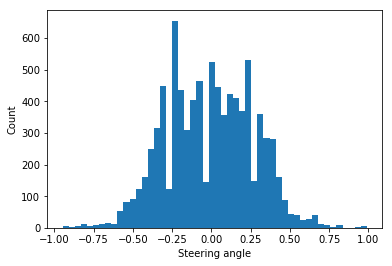

In [33]:
histogram = plt.hist(resampled_df['steering_angle'], bins=50)
plt.xlabel("Steering angle")
plt.ylabel("Count")
plt.show(histogram)

Now, it is ready to prepare data augmentaion and loader so that data is ready for training.

### Data Preparation

In this section, I will prepare DataLoader class to load and augment the data and split it into train and validation sets.

In [5]:
class DataLoader:
    def __init__(self, path, sz, filename):
        self.path = path
        self.df = self.load_data("driving_log.csv")
        self.new_df = self.load_data(filename)
        self.h, self.w, self.ch = sz
        
    def load_data(self, file_name):
        path_to_csv = os.path.join(self.path, file_name)
        df = pd.read_csv(path_to_csv)
        return df
        
    def load_image(self, file_name):
        path_to_image = os.path.join(self.path, file_name)
        image = cv2.imread(path_to_image)
        return image

    def match_X_y(self):
        new_df = pd.DataFrame(columns=['image', 'steering_angle'])
        new_df['image'] = None
        new_df['steering_angle'] = 0.
        cols = ['center', 'left', 'right']
        k = 0
        for col in cols:
            for i in range(len(self.df)):
                new_df.at[i+k, 'image'] = self.df.at[i, col]
                if col=='center':
                    new_df.at[i+k, 'steering_angle'] = self.df.at[i, 'steering']
                elif col=='left':
                    new_df.at[i+k, 'steering_angle'] = self.df.at[i, 'steering'] + 0.25
                else:
                    new_df.at[i+k, 'steering_angle'] = self.df.at[i, 'steering'] - 0.25
            k += len(self.df)
        new_df.to_csv(os.path.join(self.path, "extended_log.csv"))          
        
    def flip_horizontal(self, X_i):
        image = X_i[:, ::-1]
        return image
    
    #reference from https://subscription.packtpub.com/book/application_development/9781785283932/1/ch01lvl1sec11/image-translation
    def shift(self, X_i, y_i):
        w = X_i.shape[1]
        h = X_i.shape[0]
        #shift range between -0.10 and 0.10
        shift_w = w * (random.random()*0.2-0.1)
        shift_h = h * (random.random()*0.2-0.1)
        #adjust steering angle slightly
        s_angle = y_i + shift_w*1e-04
        #M = 2x3 transformation matrix
        M = np.float32([[1, 0, shift_w],[0, 1, shift_h]])
        #https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=getrotationmatrix2d
        image = cv2.warpAffine(X_i, M, (w, h))
        return image, s_angle
    
    def blur(self, X_i):
        random_int = random.randrange(4)
        image = gaussian(X_i, random_int, multichannel=True, mode='reflect')
        return image
    
    #reference from https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv
    def adjust_brightness(self, X_i):
        #change to hsv
        img_hsv = cv2.cvtColor(X_i, cv2.COLOR_RGB2HSV)
        #brigthness, third channel - value range is [0,255], can be darker or brighter by degree between -0.5 and 0.5
        brightness = img_hsv[:,:,2]*(random.random()-0.5)
        img_hsv[:,:,2] += brightness.astype(np.uint8)
        return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    def add_noise(self, X_i):
        image = random_noise(X_i, mode='gaussian')
        return image
    
    def split_data(self):
        if self.new_df.shape[0]:
            #split train and valid set
            X_train, X_valid, y_train, y_valid = train_test_split(self.new_df['image'], self.new_df['steering_angle'], 
                                                                  test_size=0.1, 
                                                                  random_state=42, shuffle=True)
        return X_train, X_valid, y_train, y_valid
    
    def augment_data(self, X, y):
        if len(X):
            X = X.tolist()
            y = y.tolist()
            X_augmented = []
            y_augmented = []
            for i in range(len(X)):
                X_i = self.load_image(X[i].strip())
                X_copy = copy.deepcopy(X_i)
                y_copy = copy.deepcopy(y[i])

                #random probability and threshold
                rand_prob = random.random()
                thres = 0.3
                if rand_prob > thres:
                    rand_transform = random.randrange(5)
                    if rand_transform==0:
                        X_copy = self.flip_horizontal(X_copy)
                        y_copy = -y_copy
                    if rand_transform==1:
                        X_copy, y_copy = self.shift(X_copy, y_copy)
                    if rand_transform==2:
                        X_copy = self.blur(X_copy)
                    if rand_transform==3:
                        X_copy = self.adjust_brightness(X_copy)
                    if rand_transform==4:
                        X_copy = self.add_noise(X_copy)
                X_copy = X_copy[50:-20, :, :]
                X_augmented.append(X_copy)
                y_augmented.append(y_copy)
        assert len(X_augmented)==len(y_augmented)
        return X_augmented, y_augmented       

I need to define the path to data, both images and csv files.

In [6]:
data_path = "add_data/origin_dir"
file_name = "resampled_log.csv"

Then, DataLoader is instantiated with the size of images as a parameter.

In [7]:
data = DataLoader(data_path, (160, 320, 3), file_name)

In [12]:
#create a new csv to utilise three different images
# data.match_X_y()

Then I split the data into the training and validation set - I used 10% for the validation dataset since this is the additional finetuning data. There are 7,873 images used for the training set while 875 images are reserved for the validation set. It seems to be a small dataset, however, with random data augmentation, the trainng set will be increased to 39,365.

In [8]:
X_train, X_valid, y_train, y_valid = data.split_data()

In [9]:
len(X_train), len(X_valid), len(y_train), len(y_valid)

(7873, 875, 7873, 875)

There are five data augmentation methods adopted for this project:

1. flip horizontally
2. shift along x and y axis
3. blur
4. adjust brightness
5. add noise on pixels

In [79]:
aug = ['Original', 'Horizontal flip', 'Shift', 'Blur', 'Brightness', 'Noise']
def display_image():
    f, axs = plt.subplots(1, 6, figsize = (30, 10))

    for i in range(6):
        image = plt.imread(os.path.join(data_path, X_train[0]))
        if aug[i]=='Horizontal flip':
            image = flip_horizontal(image)
        if aug[i]=='Shift':
            image,_ = shift(image, y_train[0])
        if aug[i]=='Blur':
            image = blur(image)
        if aug[i]=='Brightness':
            image = adjust_brightness(image)
        if aug[i]=='Noise':
            image = add_noise(image)
        axs[i].imshow(image)
    plt.show()

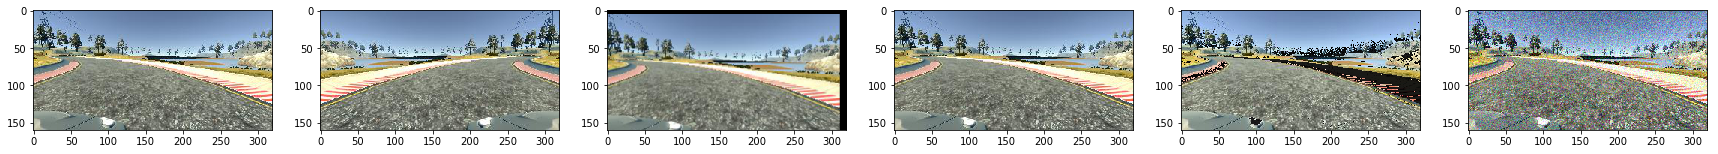

In [81]:
display_image()

In addition, a batch generator method using Python Generator is prepared to save memory and feed the data to the model smoothly.

In [9]:
def generate_batch(X, y, bs, data):
    len_X = len(X)
    #for generator, a continuous loop
    while True:
        X, y = shuffle(X, y)
        epo = 0
        #batch generator
        for offset in range(0, len_X*5, bs):
            while offset>=len_X:
                offset -= len_X
            #take a batch
            batch_X, batch_y = X[offset:offset+bs], y[offset:offset+bs]
            #augment the dataset to increase and transform images
            batch_X, batch_y = data.augment_data(batch_X, batch_y)
            
            images = []
            s_angles = []
            for i in range(len(batch_X)):
                images.append(batch_X[i])
                s_angles.append(batch_y[i])
                
            X_batch = np.array(images)
            y_batch = np.array(s_angles)
             
            yield X_batch, y_batch

## Model Architecture

As mentioned earlier, I decided to use Darknet53, the backbone of YoloV3, for a steering angle prediction. 

Darknet53 performs well utilising Resnet layers with a relatively smaller number of billions of operations and billion floating operations per second (please see the comparison table below from [YOLOv3 paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf). This is one of the reason why YoloV3 is able to produce a real-time prediction on embedded devices.

I believe that an efficient operation without sacrificing performance is crucial to computer vision components supporting self driving car engineering.

![Comparsion_between_Darknet_and_Resnet](examples/darknet53.PNG)

In [10]:
def dbl(input_data, soutput:int, skernel:int=3, stride:int=1, weight_decay=5e-04):
    """Returns a set of layers consists of Conv2D+batch_norm+Leaky_relu with alpha 0.1"""
    x = Conv2D(soutput, (skernel, skernel), padding='same', strides=stride, kernel_regularizer=l2(weight_decay))(input_data)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                 beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', 
                                 moving_variance_initializer='ones')(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

In [11]:
def res_unit(input_data, soutput:int):
    """Returns two dbl layers with residual connection - 
    first dbl half-sized output and second dbl with the original size of outputs"""
    x = dbl(input_data, soutput//2, 1)
    x = dbl(x, soutput, 3)

    return add([input_data, x])

In [12]:
def res_unit_block(input_data, soutput:int, num_block:int):
    """Returns the specified numbers of residual units e.g. 2 num_blocks returns 2 blocks of residual units"""
    x = res_unit(input_data, soutput)
    
    for i in range(num_block-1):
        x = res_unit(x, soutput)
    
    return x

I replaced the last fully connected layer, which has 1000 classes (for Imagenet dataset), and the softmax layer with only one-output fully connected layer so that the whole model can provide a single number that indicates a steering angle. Therefore, this architecture is for a regression problem, instead of a classification problem.

In [13]:
def darknet53(sinput:Collection[int], num_blocks:Collection[int], output_sz:int=32):
    """Returns 53 layers of dbl with residual connections"""
    
    input_shape = Input(shape=sinput)
    x = Lambda(lambda x: x/255.0-0.5, input_shape=sinput)(input_shape)
    
    #dbl in 3 channels, out 32 channels
    x = dbl(x, output_sz, 3, 1)

    #first - one dbl one res units - in 32 channels, out 64 channels
    x = dbl(x, output_sz*2, 3, 1)
    x = res_unit_block(x, output_sz*2, num_blocks[0])

    #second - one dbl two res units - in 64 ch, out 128 ch
    x = dbl(x, output_sz*4, 3, 2)
    x = res_unit_block(x, output_sz*4, num_blocks[1])

    #third - one dbl eight res units - in 128 ch, out 256 ch
    x = dbl(x, output_sz*8, 3, 2)
    x = res_unit_block(x, output_sz*8, num_blocks[2])

    #four - one dbl eight res units - in 256 ch, out 512 ch
    x = dbl(x, output_sz*16, 3, 2)
    x = res_unit_block(x, output_sz*16, num_blocks[3])

    #five - one dbl four res units - in 512 ch, out 1024 ch
    x = dbl(x, output_sz*32, 3, 2)
    x = res_unit_block(x, output_sz*32, num_blocks[4])

    x = GlobalAveragePooling2D()(x)
    x = Dense(units=1)(x)

    model = Model(inputs=input_shape, outputs=x)

    return model

The model will take the input size of 90 Height, 320 Width and 3 Channel (BGR from CV2) - the sky and the front of the car can be distractin factors in the images. That is why the original height of 160 is cropped to 90 pixels by removing the distractors. There are five blocks that have different number of layers: 1, 2, 8, 8, 4, respectively. I will create a model with these configurations.

In [14]:
model = darknet53((90, 320, 3), [1, 2, 8, 8, 4])

It is important to investigate the model architecture to ensure the correct configuration. In my case, I found Lambda layer was missing, by looking at the architecture below. 

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 320, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 160, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 320, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 320, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

The model has 40 millions of parameters and 52 convolutional 2D layers + batch normalisation + leaky relu layers in addition to one last fully-connected layers.

## Training

In the pipeline, I incorporated two callbacks - saving the best weights and early stopping callbacks.

In [15]:
def training_pipeline(data, model, learning_rate, filepath, bs, epoch):
    save_best = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, 
                    save_weights_only=False, mode='min', period=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=2, verbose=0, 
                                   mode='min', baseline=None, restore_best_weights=False)
    
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
    step_train = len(X_train)*5//bs+1
    step_valid = len(X_valid)*5//bs+1
    
    #https://keras.io/models/sequential/
    model.fit_generator(generate_batch(X_train, y_train, bs, data), steps_per_epoch=step_train, epochs=epoch, verbose=1, callbacks=[save_best, early_stopping], 
                        validation_data=generate_batch(X_valid, y_valid, bs, data), validation_steps=step_valid, 
                        class_weight=None, max_queue_size=10, workers=0, use_multiprocessing=False, shuffle=True, initial_epoch=0)

I need to define certain hyperparameters here, Learning rate, the number of Epoch and Batch size. 

With a number of experiment, I found that Learning rate of 0.01 for a start is OK and Batch size of 8 is maximum I can pass on with my local environment. In addition, 2 Epochs are sufficient with Learning rate of 0.01. Then, a learning rate decay is applied for subsequent epochs.

In [26]:
lr = 0.001
epoch = 1

In [27]:
bs = 8

In [28]:
model = load_model('data/data/model_03.h5')

In [29]:
training_pipeline(data, model, lr, os.path.join(data_path, 'model_01.h5'), bs, epoch)

Epoch 1/1
4921/4921 [==============================] - 1846s 375ms/step - loss: 0.1987 - val_loss: 0.1377


In [32]:
# model = load_model(os.path.join(data_path, 'model_01_nvidia.h5'))

In [30]:
lr = 0.0001
epoch = 1

In [31]:
training_pipeline(data, model, lr, os.path.join(data_path, 'model_02.h5'), bs, epoch)

Epoch 1/1
4921/4921 [==============================] - 1690s 343ms/step - loss: 0.0819 - val_loss: 0.0984


In [22]:
# model = load_model(os.path.join(data_path, 'model_02.h5'))

In [32]:
lr = 0.000001
epoch = 1

In [33]:
training_pipeline(data, model, lr, os.path.join(data_path, 'model_03.h5'), bs, epoch)

Epoch 1/1
4921/4921 [==============================] - 1287s 261ms/step - loss: 0.0536 - val_loss: 0.0509


## Result

The trained model drove well until passing the bridge on the normal track. However, the car failed to follow the track right after the bridge because it went into an appealing dirt path that resembles the track.

This is why I finetuned the model 3 additional epochs to generalise better. The final result for the normal track is below:

In [5]:
clip = (VideoFileClip("run1.mp4").resize(0.6))
clip.write_gif("project_video_normal.gif")


[MoviePy] Building file project_video_normal.gif with imageio


100%|██████████████████████████████████████████████████████████████████████████████| 7535/7535 [02:12<00:00, 56.82it/s]


![normal track](project_video_normal.gif)